<a href="https://colab.research.google.com/github/yazeedMohi/OCR-Table-Recognition/blob/main/OCR_Table_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install xlsxwriter

#**Main**

**path:** path to the input image

**excel_engine:** the engine to use when writing the excel file

**ocr:** whether or not to use OCR and recognize the image

**kernel_factor:** define how large is the detection edge kernel compared to the image width

**adaptive_filter:** define whether to use adaptive filtering for thresholding or not

**show_progress:** define whether to show images of the different stages or not

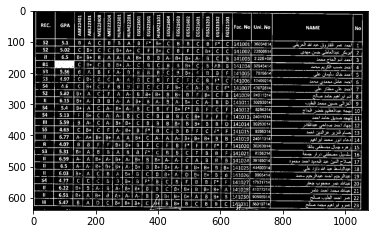

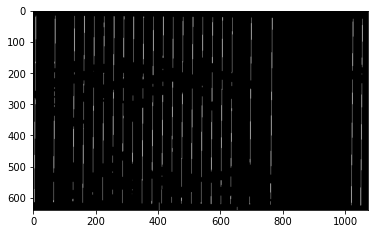

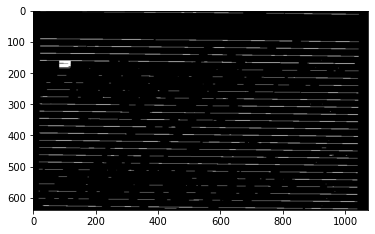

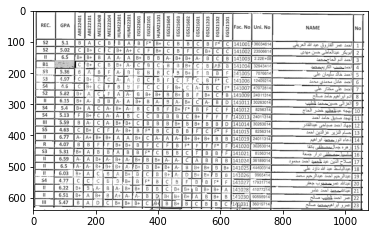

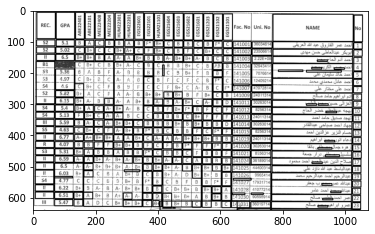

[[355, 213, 29, 90], [577, 216, 29, 44], [768, 218, 256, 46], [1027, 221, 27, 20], [134, 235, 28, 43], [642, 236, 51, 5], [701, 241, 64, 20], [1027, 244, 27, 20], [72, 257, 59, 20], [450, 261, 28, 20], [419, 261, 28, 20], [577, 262, 28, 21], [608, 263, 89, 20], [701, 264, 63, 20], [768, 265, 255, 22], [1027, 268, 26, 19], [72, 280, 58, 20], [134, 281, 28, 20], [229, 282, 28, 19], [481, 284, 29, 43], [450, 284, 28, 43], [419, 284, 28, 20], [387, 284, 28, 19], [545, 285, 28, 20], [639, 286, 58, 20], [608, 286, 28, 20], [577, 286, 28, 20], [700, 287, 64, 20], [767, 288, 256, 22], [1027, 291, 26, 19], [914, 299, 32, 5], [876, 299, 33, 5], [9, 302, 59, 21], [71, 303, 59, 20], [165, 304, 28, 20], [134, 304, 28, 19], [260, 305, 28, 20], [228, 305, 29, 20], [197, 305, 28, 19], [355, 306, 28, 43], [418, 307, 28, 20], [386, 307, 29, 19], [545, 308, 28, 21], [513, 308, 28, 20], [640, 309, 57, 20], [608, 309, 28, 20], [576, 309, 28, 20], [700, 310, 64, 20], [767, 311, 256, 22], [1026, 314, 27, 19]

In [49]:
Main()

In [48]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

def Main(path="/content/sample.PNG", excel_engine="xlsxwriter", ocr=True, kernel_factor=100, morph_kernel=2, adaptive_filter = False, show_progress = True):
  #read your file
  file=r'/content/sample.PNG'
  img = cv2.imread(file,0)
  img.shape

  #thresholding the image to a binary image
  if(adaptive_filter):
    img_bin = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
  else:
    thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  #inverting the image 
  img_bin = 255-img_bin
  cv2.imwrite('/content/cv_inverted.png',img_bin)
  #Plotting the image to see the output
  if(show_progress):
    plotting = plt.imshow(img_bin,cmap='gray')
    plt.show()

  # countcol(width) of kernel as 100th of total width
  kernel_len = np.array(img).shape[1]//kernel_factor
  # Defining a vertical kernel to detect all vertical lines of image 
  ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
  # Defining a horizontal kernel to detect all horizontal lines of image
  hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
  # A kernel of 2x2
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (morph_kernel, morph_kernel))

  #Use vertical kernel to detect and save the vertical lines in a jpg
  image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
  vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
  cv2.imwrite("/content/vertical.jpg",vertical_lines)
  #Plot the generated image
  if(show_progress):
    plotting = plt.imshow(image_1,cmap='gray')
    plt.show()

  #Use horizontal kernel to detect and save the horizontal lines in a jpg
  image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
  horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
  cv2.imwrite("/content/horizontal.jpg",horizontal_lines)
  #Plot the generated image
  if(show_progress):
    plotting = plt.imshow(image_2,cmap='gray')
    plt.show()

  # Combine horizontal and vertical lines in a new third image, with both having same weight.
  img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
  #Eroding and thesholding the image
  img_vh = cv2.erode(~img_vh, kernel, iterations=2)
  if(adaptive_filter):
    img_vh = cv2.adaptiveThreshold(img_vh,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
  else:
    thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  cv2.imwrite("/content/img_vh.jpg", img_vh)
  bitxor = cv2.bitwise_xor(img,img_vh)
  bitnot = cv2.bitwise_not(bitxor)
  #Plotting the generated image
  if(show_progress):
    plotting = plt.imshow(bitnot,cmap='gray')
    plt.show()

  # Detect contours for following box detection
  contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  def sort_contours(cnts, method="left-to-right"):
      # initialize the reverse flag and sort index
      reverse = False
      i = 0
      # handle if we need to sort in reverse
      if method == "right-to-left" or method == "bottom-to-top":
          reverse = True
      # handle if we are sorting against the y-coordinate rather than
      # the x-coordinate of the bounding box
      if method == "top-to-bottom" or method == "bottom-to-top":
          i = 1
      # construct the list of bounding boxes and sort them from top to
      # bottom
      boundingBoxes = [cv2.boundingRect(c) for c in cnts]
      (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
      key=lambda b:b[1][i], reverse=reverse))
      # return the list of sorted contours and bounding boxes
      return (cnts, boundingBoxes)

  # Sort all the contours by top to bottom.
  contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

  #Creating a list of heights for all detected boxes
  heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

  #Get mean of heights
  mean = np.mean(heights)

  #Create list box to store all boxes in  
  box = []
  # Get position (x,y), width and height for every contour and show the contour on image
  for c in contours:
      x, y, w, h = cv2.boundingRect(c)
      if (w<1000 and h<500):
          image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
          box.append([x,y,w,h])

  if(show_progress):        
    plotting = plt.imshow(image,cmap='gray')
    plt.show()

  #Creating two lists to define row and column in which cell is located
  row=[]
  column=[]
  j=0

  #Sorting the boxes to their respective row and column
  for i in range(len(box)):    
          
      if(i==0):
          column.append(box[i])
          previous=box[i]    
      
      else:
          if(box[i][1]<=previous[1]+mean/2):
              column.append(box[i])
              previous=box[i]            
              
              if(i==len(box)-1):
                  row.append(column)        
              
          else:
              row.append(column)
              column=[]
              previous = box[i]
              column.append(box[i])

  if(show_progress):          
    print(column)
    print(row)

  #calculating maximum number of cells
  max_countcol = 0
  for i in range(len(row)):
      countcol = len(row[i])
      if countcol > max_countcol:
          max_countcol = countcol

  countcol = max_countcol

  #Retrieving the center of each column
  center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]

  center=np.array(center)
  center.sort()
  if(show_progress):
    print(center)

  #Regarding the distance to the columns center, the boxes are arranged in respective order

  finalboxes = []
  for i in range(len(row)):
      lis=[]
      for k in range(countcol):
          lis.append([])
      for j in range(len(row[i])):
          diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
          minimum = min(diff)
          indexing = list(diff).index(minimum)
          lis[indexing].append(row[i][j])
      finalboxes.append(lis)

  if(ocr):
    #from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
    outer=[]
    for i in range(len(finalboxes)):
        for j in range(len(finalboxes[i])):
            inner=''
            if(len(finalboxes[i][j])==0):
                outer.append(' ')
            else:
                for k in range(len(finalboxes[i][j])):
                    y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                    finalimg = bitnot[x:x+h, y:y+w]
                    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                    border = cv2.copyMakeBorder(finalimg,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                    resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                    dilation = cv2.dilate(resizing, kernel,iterations=1)
                    erosion = cv2.erode(dilation, kernel,iterations=2)
                    
                    out = pytesseract.image_to_string(erosion)
                    if(len(out)==0):
                        out = pytesseract.image_to_string(erosion, config='--psm 3')
                    inner = inner +" "+ out
                outer.append(inner)

    #Creating a dataframe of the generated OCR list
    arr = np.array(outer)
    dataframe = pd.DataFrame(arr.reshape(len(row), countcol))
    print(dataframe)
    data = dataframe.style.set_properties(align="left")
    #Converting it in a excel-file
    data.to_excel("/content/test.xlsx", engine='xlsxwriter')